## Introduction

This project aims to utilize data queried from the ERA5 Reanalysis Product to identify and analyze any long term trends that appear. The data captures 80 years of daily sea surface temperature, wave height, and wind speed data from seven major ocean basins: the Arctic, North Atlantic, South Atlantic, Indian, North Pacific, South Pacific, and Southern Oceans.

All data and code is hosted on Github at https://github.com/MCaiGH/Climate-Analysis/tree/main.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from prophet import Prophet

## Load Oceans Data

In [2]:
indian = pd.read_csv('https://raw.githubusercontent.com/MCaiGH/Climate-Analysis/main/Data/indian.csv')
north_atlantic = pd.read_csv('https://raw.githubusercontent.com/MCaiGH/Climate-Analysis/main/Data/north_atlantic.csv')
north_pacific = pd.read_csv('https://raw.githubusercontent.com/MCaiGH/Climate-Analysis/main/Data/north_pacific.csv')
south_atlantic = pd.read_csv('https://raw.githubusercontent.com/MCaiGH/Climate-Analysis/main/Data/south_atlantic.csv')
south_pacific = pd.read_csv('https://raw.githubusercontent.com/MCaiGH/Climate-Analysis/main/Data/south_pacific.csv')

I have performed .describe() for each dataframe and their aren't any erroneous values that I noticed, not including the code as it would clutter the notebook.

In [3]:
for df in [indian, north_atlantic, north_pacific, south_atlantic, south_pacific]:
  print(df.isnull().sum())

sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64
sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64
sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64
sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64
sst          0
u10          0
hsig         0
time         0
latitude     0
longitude    0
dtype: int64


## Combine datasets into one

In [4]:
combined_df = pd.concat([indian, north_atlantic, north_pacific, south_atlantic, south_pacific], ignore_index=True)
combined_df['time'] = pd.to_datetime(combined_df['time'])
daily_avg_sst = combined_df.groupby(pd.Grouper(key='time', freq='D'))['sst'].mean()
ocean = pd.DataFrame({'time': daily_avg_sst.index, 'average_sst': daily_avg_sst})
ocean.set_index('time', inplace=True)
sst = ocean["average_sst"].values.reshape(-1, 1)
time = np.arange(len(ocean))

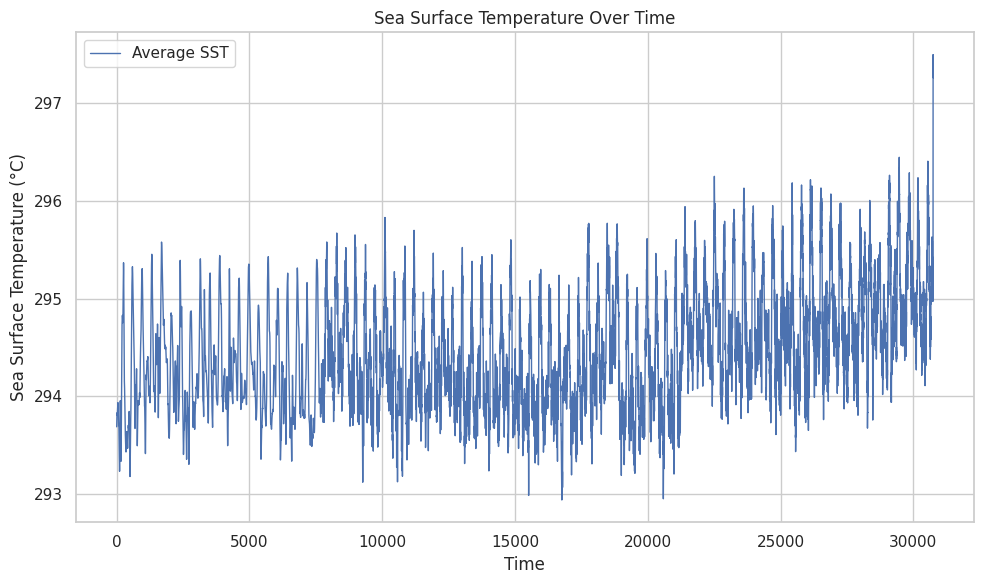

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(time, sst, linewidth=1, label='Average SST')
plt.title('Sea Surface Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
ocean.head()

,average_sst
time,
1940-01-01,293.686146
1940-01-02,293.702924
1940-01-03,293.724836
1940-01-04,293.741700
1940-01-05,293.757200


## State your question

What notable frequencies show up in ocean surface temperature over time, can we identify them? How can we used time series forecasting to predict future surface temperatures.

## Analysis

### Spectral Density of Sea Surface Temperatures

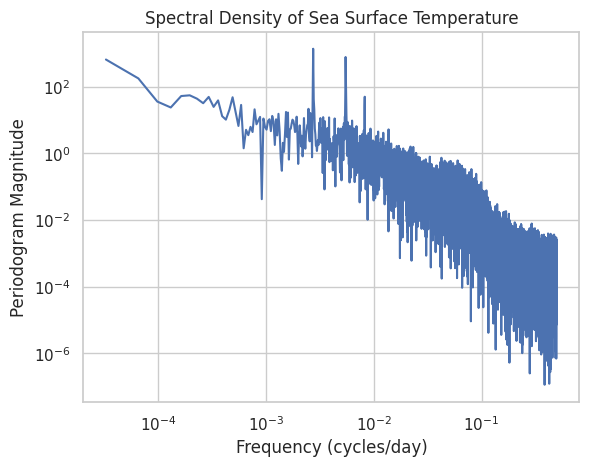

In [7]:
sst = ocean["average_sst"].values
n = len(sst)
dt = 1
fs = 1 / dt
p = int((n - 1) / 2)
dft = np.fft.fft(sst)[:p + 1]
P_from_dft = (np.abs(dft)**2) / n
frequency = np.fft.fftfreq(n, dt)[:p + 1]

fig, ax = plt.subplots()
ax.plot(frequency[1:], P_from_dft[1:])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Periodogram Magnitude")
ax.set_title("Spectral Density of Sea Surface Temperature")
plt.show()

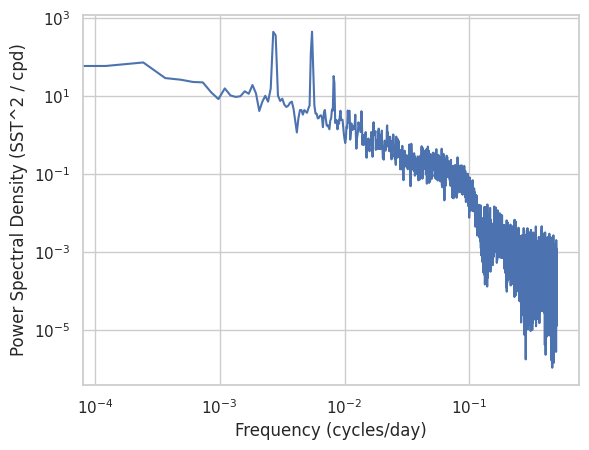

In [8]:
f, Pw = welch(sst, fs=1.0, window="hamming", nperseg=8192)
fig, ax = plt.subplots()
ax.plot(f, Pw)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

### Moving Average

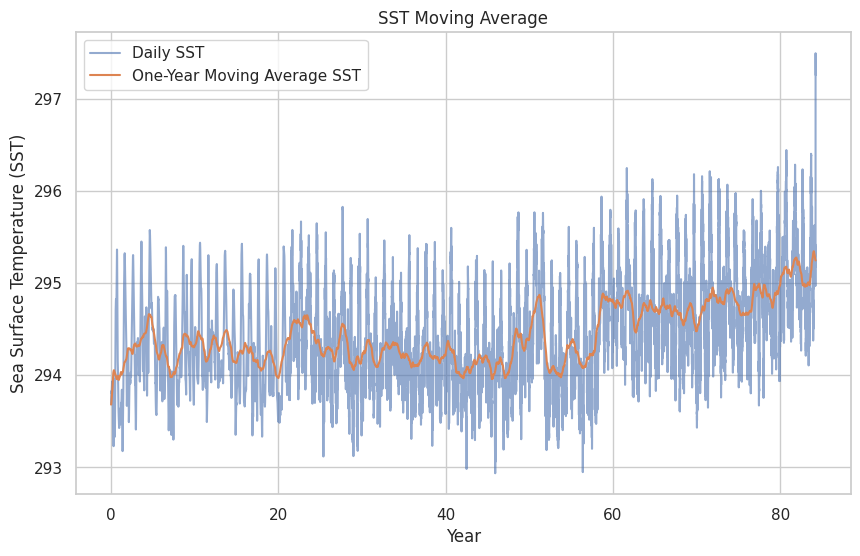

In [9]:
sst = ocean["average_sst"].values
t = np.arange(len(sst))

window_len = 365
sst_ma = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, sst, alpha=0.6, label="Daily SST")
ax.plot(t / 365, sst_ma, label="One-Year Moving Average SST")
ax.set_xlabel("Year")
ax.set_ylabel("Sea Surface Temperature (SST)")
ax.set_title("SST Moving Average")
ax.legend()
fig.set_size_inches(10, 6)


### Forecasting with Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi0xz0vj6/6qw5b9gz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi0xz0vj6/eggs7f6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44524', 'data', 'file=/tmp/tmpi0xz0vj6/6qw5b9gz.json', 'init=/tmp/tmpi0xz0vj6/eggs7f6b.json', 'output', 'file=/tmp/tmpi0xz0vj6/prophet_modeloh49d3pv/prophet_model-20240521111708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


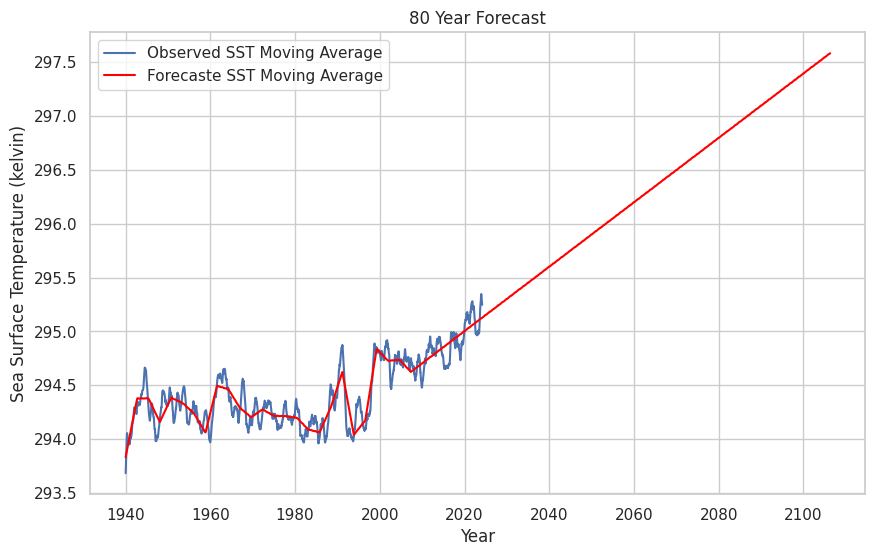

In [11]:
frame = pd.DataFrame({"ds": ocean.index, "y": sst_ma})
m = Prophet()
m.fit(frame)

future = m.make_future_dataframe(periods=30000)
forecast = m.predict(future)

fig, ax = plt.subplots()
ax.plot(frame["ds"], frame["y"], label="Observed SST Moving Average")
ax.plot(forecast["ds"], forecast["yhat"], label="Forecaste SST Moving Average", color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Sea Surface Temperature (kelvin)")
ax.set_title("80 Year Forecast")
ax.legend()
fig.set_size_inches(10, 6)
plt.show()


### Lagged Regression

In [12]:
k = 4

sst = ocean["average_sst"].values.reshape(-1, 1)

train_indices = list(range(len(ocean) // 2))
test_indices = list(range(len(ocean) // 2, len(ocean)))

sst_train = sst[train_indices, :]
sst_test = sst[test_indices, :]
sst_lagged_train = sst_train[:-k, :]
sst_lagged_test = sst_test[:-k, :]

sst_target_train = sst_train[k:, :]
sst_target_test = sst_test[k:, :]
reg = LinearRegression().fit(sst_lagged_train, sst_target_train)
sst_predicted = reg.predict(sst_lagged_test)
mae = np.nanmean(np.abs(sst_predicted - sst_target_test))


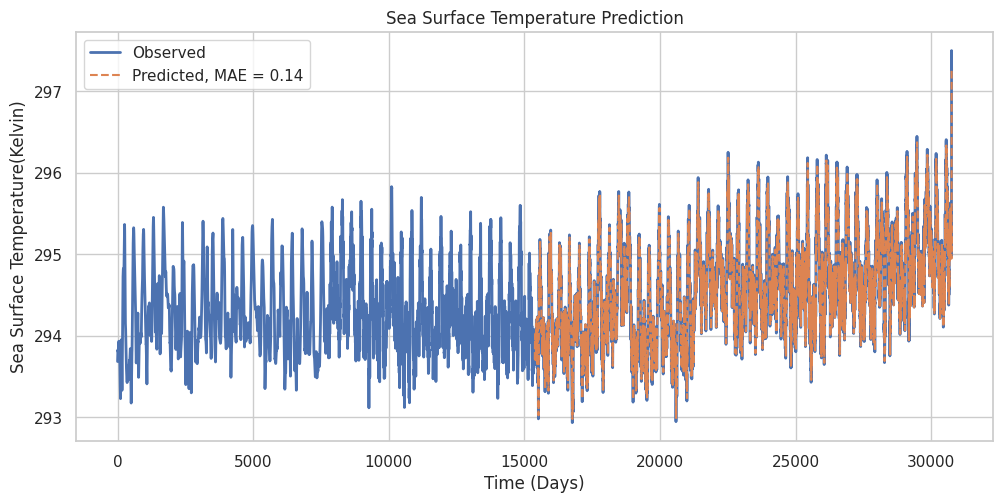

In [13]:
fig, ax = plt.subplots()
ax.plot(time, sst, '-', linewidth=2, label="Observed")
ax.plot(time[test_indices[k:]], sst_predicted, '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Sea Surface Temperature(Kelvin)")
ax.set_title("Sea Surface Temperature Prediction")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

Attempted lagged regression, wasn't successful.

## Conclusion

After my analysis, I have identified that sea surface temperatures fluctuate yearly with peak temperatures returning at the same time every year. This was confirmed with out spectral analysis where we noticed a peak in the .00274 cycles per year which lines up to once every 365 days. I also identified a positive trend in average sea surface temperatures throughout the years. If forecasted out 80 years, it predicts that average sea surface temperatures will reach 297.5 Kelvin.